# Boston Housing data


This part of the tutorial loads data about Boston housing and median house prices. The goal is to predict the housing price in each district given a series of features.

Features include race, air quality and plot size.

<table><tr><td><img src="boston_roads.png" width="70%" height="70%"></td><td><img src="colorful_row_houses.jpg" width="70%" height="70%"></td></tr>
</table>

In [47]:
# Load the data
import warnings
from sklearn.datasets import load_boston

TRAIN_SIZE = 100

warnings.filterwarnings('ignore')

boston = load_boston()
X_train = boston["data"][:TRAIN_SIZE]
y_train = boston["target"][:TRAIN_SIZE]
X_test = boston["data"][TRAIN_SIZE:]
y_test = boston["target"][TRAIN_SIZE:]

all_features = boston["feature_names"]


Next let's see some of the data. X is a matrix of all feature values. y is a vector of target data.

In [53]:
all_features = boston["feature_names"]
print str(all_features)
print 'y training size is %d' % len(y_train)
print 'X training size is %d x %d' % (len(X_train[0]), len(X_train))
print 'y training set is in $k %s' % str(y_train[:5])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'MEDV']
y training size is 100
X training size is 13 x 100
y training set is in $k [ 24.   21.6  34.7  33.4  36.2]


# Linear regression

Let's try a couple of models. First a linear regression based on least squares. The variance should be close to 1 if the model is good. Don't be fooled by the R^2 on the training set. It's a line that does not describe the reality of taking on a real set of new random data.

In [11]:
from sklearn import linear_model
from sklearn.metrics import r2_score

clf_linear_simple = linear_model.LinearRegression()

clf_linear_simple.fit (X_train, y_train)
linear_r2 = r2_score(y_train, clf_linear_simple.predict(X_train))
print 'R^2 train is %f # bogus' % linear_r2
linear_test_r2 = r2_score(y_test, clf_linear_simple.predict(X_test))
print 'R^2 test is %f' % linear_test_r2


R^2 train is 0.880705 # bogus
R^2 test is -12.723166


#Plot Data
Fet a feel for plotting data.
FOR THE STUDENT:
Increase FEATURES_TO_SHOW to see all 13 features.

Feature: CRIM


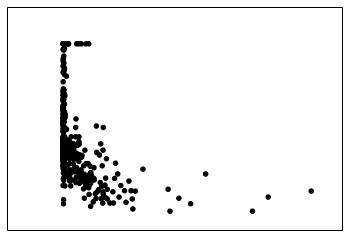

Feature: ZN


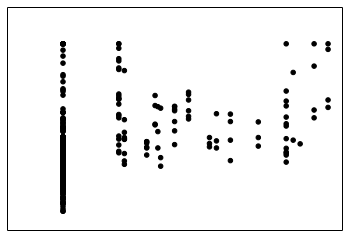

In [97]:
# LET's plot it
import matplotlib.pyplot as plt
# ALLOW inline graphs
%matplotlib inline

# FOR THE student:
# Look at more graphs of features and find those that look to be the best
# fits

FEATURES_TO_SHOW = 2

for feature_name in all_features[:FEATURES_TO_SHOW]:
    print 'Feature: %s' % feature_name
    #idx = list(all_features).index('LSTAT')
    idx = list(all_features).index(feature_name)
    plt.scatter([x[idx] for x in X_test], y_test,  color='black')

    plt.xticks(())
    plt.yticks(())

    plt.show()


#housing.main()

##Feature Selection
We try to find the best features using a series of random sets. Starty by importing the data and using the random forest regressor to select features.

In [18]:
from collections import defaultdict
from sklearn.cross_validation import ShuffleSplit
import numpy as np


X = boston["data"]
Y = boston["target"]
 
rf_cross = RandomForestRegressor()
scores = defaultdict(list)

#Cross Validation
Cross validation is used to test models and features against a different split of the data each time. ShuffleSplit splits the data into different sets for training and test.

In [22]:
#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train_shuf, X_test_shuf = X[train_idx], X[test_idx]
    Y_train_shuf, Y_test_shuf = Y[train_idx], Y[test_idx]
    r = rf_cross.fit(X_train_shuf, Y_train_shuf)

    acc = r2_score(Y_test_shuf, rf_cross.predict(X_test_shuf))
    for i in range(X.shape[1]):
        X_t = X_test_shuf.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test_shuf, rf_cross.predict(X_t))

        scores[all_features[i]].append((acc-shuff_acc)/acc)

#Print Top Features with Scores

In [25]:
print "Features sorted by their score:"
sorted_features = sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True)
print sorted_features
good_features = [x[1] for x in sorted_features]


Features sorted by their score:
[(0.7849, 'LSTAT'), (0.5417, 'RM'), (0.0828, 'DIS'), (0.0443, 'NOX'), (0.0418, 'CRIM'), (0.0225, 'PTRATIO'), (0.0168, 'TAX'), (0.0109, 'AGE'), (0.0063, 'B'), (0.0058, 'INDUS'), (0.0042, 'RAD'), (0.0002, 'CHAS'), (-0.0001, 'ZN')]


#Make a reduced set
Make slimmed down training and test set. Try to get over .5 R-squared.

In [44]:
# TO THE STUDENT:
# Change this to use different top features

FEATURE_COUNT = 4


# USE good features to train next model
X_selected_train = []
X_selected_test = []

for line in X_train:
    x_out = []
    feature_num = 0
    for feature_name in all_features:
        if feature_name in good_features[:FEATURE_COUNT]:
            x_out.append(line[feature_num])
        feature_num += 1
    X_selected_train.append(x_out)

for line in X_test:
    x_out = []
    feature_num = 0
    for feature_name in all_features:
        if feature_name in good_features[:FEATURE_COUNT]:
            x_out.append(line[feature_num])
        feature_num += 1
    X_selected_test.append(x_out)
    clf_select = linear_model.LinearRegression()

clf_select.fit (X_selected_train, y_train)
print('R^2 selected train linear score: %.2f # bogus' % clf_select.score(X_selected_train, y_train))
print('R^2 selected test linear score: %.2f' % clf_select.score(X_selected_test, y_test))

R^2 selected train linear score: 0.82 # bogus
R^2 selected test linear score: 0.52


# Feature Scaling
Feature scaling helps prevent some features from appearing to dominate a training set.

In [39]:
# SCALE it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#Test Scaling
Test the scaled version.

In [41]:
clf = linear_model.LinearRegression()

clf.fit(X_train_scaled, y_train)
X_test_scaled = scaler.fit_transform(X_test)

print('R^2 test scaled linear score: %.2f' % clf.score(X_test_scaled, y_test))

R^2 test scaled linear score: 0.50


#Test Scaled and Selected Data

In [43]:
X_train_select_scaled = scaler.fit_transform(X_selected_train)
X_test_select_scaled = scaler.fit_transform(X_selected_test)


clf_select_scaled = linear_model.LinearRegression()
clf_select_scaled.fit(X_train_select_scaled, y_train)
print('R^2 test select scaled linear score: %.2f' % clf_select_scaled.score(X_test_select_scaled, y_test))

R^2 test select scaled linear score: 0.55


# Ridiculously Easy Alert

# Random Forest
The random forest optimizes the results under the hood. This is the easy way. This is an overestimate of the R^2 again. This really is random. Try play twice and watch the score.

In [1]:
from sklearn.ensemble import RandomForestRegressor
rf_first = RandomForestRegressor(n_estimators=20, max_depth=4)
rf_first.fit(X_train, y_train)
linear_r2 = r2_score(y_train, rf_first.predict(X_train))
print('R^2 score: %.2f' % rf_first.score(X_test, y_test))

NameError: name 'X_train' is not defined

#Appendix
What do these features mean?

1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to five Boston employment centres
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per 10,000 dollars
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT: Percent lower status of the population
14. MEDV: Median value of owner-occupied homes in 1000s of dollars